In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
from scipy import ndimage
from shutil import copyfile
import cv2
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input, Flatten, Dropout, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gradio as gr

In [8]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cifake-real-and-ai-generated-synthetic-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3041726%2F5256696%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240614%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240614T153038Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5ca84c2f6739bd1f97d5742fc6661e2ff0e37df986a6be661d91b1af6909cdc67c117f9d273cac1637e187d4553ad44b0205d8f586b49f596fee408608708dcc9d9d36f2fddbd7d6659391dbbe90b3c0b1a48f45b78bfc25137a4d5daa05d52932f1a753f08ef282833ece4132ddb0fb5786b9a41430f53fe2a2e7d410728a6229cd4b0036ef852acd43ff614f703c756aca912be8254bddf4fa2d480ebe7fa47993b09364fc26f8dac492263b0fcf13c90639d6ac1e042b050d8e69696c95963c2e329af1acddc6f96109ca4c0a3895c53d4f11b8516c85735b85445c67b837b3cfe5a85085a5b74856837794a60e910b3266150b7d2e7a1e173cbc7f1bedc4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 109625224 bytes downloaded
Downloaded and uncompressed: cifake-real-and-ai-generated-synthetic-images
Data source import complete.


In [10]:
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def sample_and_copy_images(src_directory, dest_directory, sample_fraction=0.25):
    create_directory(dest_directory)
    for sub_dir in ['FAKE', 'REAL']:
        src_path = os.path.join(src_directory, sub_dir)
        dest_path = os.path.join(dest_directory, sub_dir)
        create_directory(dest_path)

        # Get list of all files in the source directory
        all_files = os.listdir(src_path)

        # Calculate number of samples to take
        num_samples = int(len(all_files) * sample_fraction)

        # Randomly sample files
        sampled_files = random.sample(all_files, num_samples)

        # Copy sampled files to destination directory
        for file_name in sampled_files:
            shutil.copy(os.path.join(src_path, file_name), os.path.join(dest_path, file_name))

# Define source and destination directories
src_train_directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
src_test_directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

dest_directory = '/kaggle/working/sampled_data'

# Sample and copy images for train and test datasets
sample_and_copy_images(src_train_directory, os.path.join(dest_directory, 'train'), sample_fraction=0.25)
sample_and_copy_images(src_test_directory, os.path.join(dest_directory, 'test'), sample_fraction=0.25)

print(f"Sampled images have been copied to {dest_directory}")

Sampled images have been copied to /kaggle/working/sampled_data


In [11]:
def load_image_paths_and_labels(directory):
    data = []
    labels = []
    for label, sub_dir in enumerate(['FAKE', 'REAL']):
        path = os.path.join(directory, sub_dir)
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            data.append(file_path)
            labels.append('FAKE' if label == 0 else 'REAL')
    return data, labels

# Load train and test image paths and labels
train_paths, train_labels = load_image_paths_and_labels(os.path.join(dest_directory, 'train'))
test_paths, test_labels = load_image_paths_and_labels(os.path.join(dest_directory, 'test'))

# Split the training data into training and validation sets (80% train, 20% validation)
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [12]:
def image_whitening(image):
    mean = np.mean(image)
    std = np.std(image)
    whitened_image = (image - mean) / std
    return whitened_image

def image_normalization(image):
    normalized_image = image / 255.0
    return normalized_image

In [13]:
# Create an instance of the ImageDataGenerator with preprocessing functions
datagen = ImageDataGenerator(preprocessing_function=lambda x: image_whitening(image_normalization(x)))

# data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': valid_paths, 'class': valid_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [14]:
# Define the CNN model
model = Sequential([
    Conv2D(26, (3, 3), input_shape=(64, 64, 3)),
    LeakyReLU(alpha=0.1),
    AveragePooling2D((2, 2)),
    Conv2D(32, (3, 3)),
    LeakyReLU(alpha=0.1),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model using generators
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    callbacks=[early_stopping],
                    verbose=1)

# Clear memory
import gc
gc.collect()

Epoch 1/20
625/625 [==============================] - 23s 25ms/step - loss: 0.6794 - accuracy: 0.5602 - val_loss: 0.6513 - val_accuracy: 0.6458
Epoch 2/20
625/625 [==============================] - 17s 27ms/step - loss: 0.6363 - accuracy: 0.6489 - val_loss: 0.5644 - val_accuracy: 0.7600
Epoch 3/20
625/625 [==============================] - 15s 25ms/step - loss: 0.5926 - accuracy: 0.6965 - val_loss: 0.5104 - val_accuracy: 0.7978
Epoch 4/20
625/625 [==============================] - 16s 25ms/step - loss: 0.5504 - accuracy: 0.7314 - val_loss: 0.4551 - val_accuracy: 0.8264
Epoch 5/20
625/625 [==============================] - 15s 25ms/step - loss: 0.5381 - accuracy: 0.7399 - val_loss: 0.4846 - val_accuracy: 0.7884
Epoch 6/20
625/625 [==============================] - 15s 25ms/step - loss: 0.5050 - accuracy: 0.7641 - val_loss: 0.4454 - val_accuracy: 0.8212
Epoch 7/20
625/625 [==============================] - 15s 25ms/step - loss: 0.4780 - accuracy: 0.7738 - val_loss: 0.3764 - val_accuracy:

24

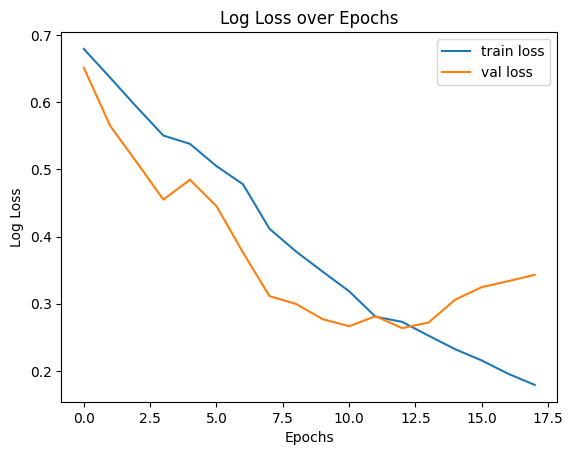

157/157 [==============================] - 3s 22ms/step - loss: 0.2751 - accuracy: 0.8910
Test loss: 0.27505388855934143
Test accuracy: 0.890999972820282


In [15]:
# log loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.title('Log Loss over Epochs')
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [22]:
#image preprocessing functions
def preprocess_image(image_path, target_size=(64, 64)):
    image = imread(image_path)
    image_resized = resize(image, target_size, anti_aliasing=True)
    image_normalized = image_normalization(image_resized)
    image_whitened = image_whitening(image_normalized)
    return np.expand_dims(image_whitened, axis=0)  # Add batch dimension

#function to classify an image
def classify_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {0: 'FAKE', 1: 'REAL'}
    return class_labels[class_idx], prediction[0][class_idx]

# Example
image_path = '/WhatsApp Image 2024-05-18 at 15.40.00_8dc47749.jpg'
label, confidence = classify_image(image_path)
print(f"The image is classified as {label} with confidence {confidence:.2f}")


1/1 [==============================] - 0s 17ms/step
The image is classified as REAL with confidence 0.81


In [27]:
tf.keras.models.save_model(model,'my_model2.hdf5')

<ipython-input-27-07e813155dae>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model2.hdf5')


In [29]:
!pip install flask

In [31]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.9 MB/s

In [9]:
tf.keras.models.save_model(model,'my_model2.hdf5')

<ipython-input-9-07e813155dae>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model2.hdf5')


In [36]:
# Load your trained model
model = load_model('/content/my_model2.hdf5')

# image preprocessing functions
def preprocess_image(image, target_size=(64, 64)):
    img_resized = resize(image, target_size, anti_aliasing=True)
    img_normalized = image_normalization(img_resized)
    img_whitened = image_whitening(img_normalized)
    return np.expand_dims(img_whitened, axis=0)

# function to classify an image
def classify_image(image):
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {0: 'FAKE', 1: 'REAL'}
    return class_labels[class_idx], float(prediction[0][class_idx])

# Gradio interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=[gr.Textbox(label="Class"), gr.Number(label="Confidence")],
    title="Image Classification",
    description="Upload an image to classify it as REAL or FAKE."
)

interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c4576c5d93556c9930.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


OUR OTHER ATTEMPTS

1. Training using ResNet50. (rejected due to low accuracy)

In [ ]:
# #ResNet50
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Reshape
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping

# # Load the ResNet50 model, excluding the top layers
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# # Add custom layers on top of ResNet50
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# cnn_model = Sequential([
#     Conv2D(16, (3, 3), input_shape=(64, 64, 3)),
#     LeakyReLU(alpha=0.1),
#     AveragePooling2D((2, 2)),
#     Conv2D(32, (3, 3)),
#     LeakyReLU(alpha=0.1),
#     AveragePooling2D((2, 2)),
#     Conv2D(64, (3, 3)),
#     LeakyReLU(alpha=0.1),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])
# x = Flatten()(x)
# x = Dense(64*64*3, activation='relu')(x)  # Reshape to be compatible with the custom CNN input
# x = Reshape((64, 64, 3))(x)
# output = cnn_model(x)

# # Define the model
# model = Model(inputs=base_model.input, outputs=output)

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model using generators
# history = model.fit(train_generator,
#                     validation_data=valid_generator,
#                     epochs=20,
#                     callbacks=[early_stopping],
#                     verbose=1)

# # Clear memory
# import gc
# gc.collect()

Epoch 1/20
625/625 [==============================] - 31s 40ms/step - loss: 0.5375 - accuracy: 0.7330 - val_loss: 0.5113 - val_accuracy: 0.7456
Epoch 2/20
625/625 [==============================] - 24s 38ms/step - loss: 0.4773 - accuracy: 0.7719 - val_loss: 0.4809 - val_accuracy: 0.7766
Epoch 3/20
625/625 [==============================] - 24s 39ms/step - loss: 0.4525 - accuracy: 0.7883 - val_loss: 0.4662 - val_accuracy: 0.7718
Epoch 4/20
625/625 [==============================] - 25s 40ms/step - loss: 0.4317 - accuracy: 0.8015 - val_loss: 0.4686 - val_accuracy: 0.7848
Epoch 5/20
625/625 [==============================] - 26s 42ms/step - loss: 0.4177 - accuracy: 0.8100 - val_loss: 0.4474 - val_accuracy: 0.7900
Epoch 6/20
625/625 [==============================] - 24s 38ms/step - loss: 0.4015 - accuracy: 0.8185 - val_loss: 0.4513 - val_accuracy: 0.7924
Epoch 7/20
625/625 [==============================] - 25s 41ms/step - loss: 0.3818 - accuracy: 0.8290 - val_loss: 0.4552 - val_accuracy:

19634

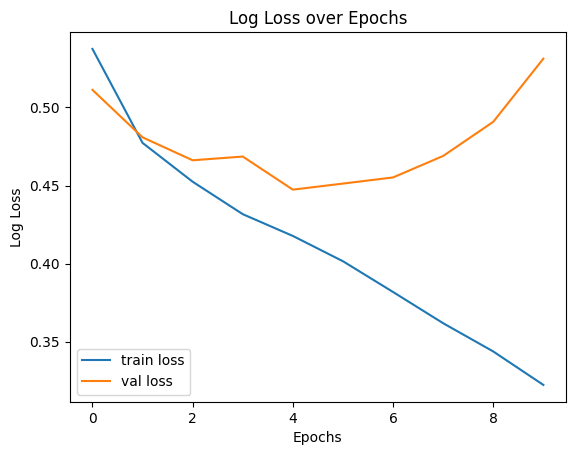

157/157 [==============================] - 4s 25ms/step - loss: 0.4692 - accuracy: 0.7786
Test loss: 0.469226598739624
Test accuracy: 0.7785999774932861


In [ ]:
# # Plot log loss
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.xlabel('Epochs')
# plt.ylabel('Log Loss')
# plt.legend()
# plt.title('Log Loss over Epochs')
# plt.show()

# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f'Test loss: {test_loss}')
# print(f'Test accuracy: {test_accuracy}')


2. Training using Ensemble on CNN. (rejected due to very high computation time)

In [ ]:
# import os
# import shutil
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from skimage.io import imread
# from skimage.transform import resize
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# import random
# import matplotlib.pyplot as plt

# # Function to create a directory if it doesn't exist
# def create_directory(directory_path):
#     if not os.path.exists(directory_path):
#         os.makedirs(directory_path)

# # Function to sample and copy images from source to destination
# def sample_and_copy_images(src_directory, dest_directory, sample_fraction=0.2):
#     create_directory(dest_directory)
#     for sub_dir in ['FAKE', 'REAL']:
#         src_path = os.path.join(src_directory, sub_dir)
#         dest_path = os.path.join(dest_directory, sub_dir)
#         create_directory(dest_path)

#         all_files = os.listdir(src_path)
#         num_samples = int(len(all_files) * sample_fraction)
#         sampled_files = random.sample(all_files, num_samples)

#         for file_name in sampled_files:
#             shutil.copy(os.path.join(src_path, file_name), os.path.join(dest_path, file_name))

# # Directories
# src_train_directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
# src_test_directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'
# dest_directory = '/kaggle/working/sampled_data'

# # Sample and copy images for initial training
# sample_and_copy_images(src_train_directory, os.path.join(dest_directory, 'initial_train'), sample_fraction=0.2)
# sample_and_copy_images(src_test_directory, os.path.join(dest_directory, 'test'), sample_fraction=0.2)

# # Load image paths and labels
# def load_image_paths_and_labels(directory):
#     data = []
#     labels = []
#     for label, sub_dir in enumerate(['FAKE', 'REAL']):
#         path = os.path.join(directory, sub_dir)
#         for file_name in os.listdir(path):
#             file_path = os.path.join(path, file_name)
#             data.append(file_path)
#             labels.append('FAKE' if label == 0 else 'REAL')
#     return data, labels

# train_paths, train_labels = load_image_paths_and_labels(os.path.join(dest_directory, 'initial_train'))

# # Data generators with data augmentation
# datagen = ImageDataGenerator(
#     preprocessing_function=lambda x: (x / 255.0 - np.mean(x / 255.0)) / np.std(x / 255.0),
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# def create_model():
#     model = Sequential([
#         Conv2D(32, (3, 3), input_shape=(64, 64, 3)),
#         LeakyReLU(alpha=0.1),
#         AveragePooling2D((2, 2)),
#         Conv2D(64, (3, 3)),
#         LeakyReLU(alpha=0.1),
#         AveragePooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(2, activation='softmax')
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# def train_and_boost(train_paths, train_labels, n_models=5):
#     trained_models = []
#     for i in range(n_models):
#         # Split into training and validation sets
#         X_train, X_valid, y_train, y_valid = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

#         train_generator = datagen.flow_from_dataframe(
#             dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
#             x_col='filename',
#             y_col='class',
#             target_size=(64, 64),
#             batch_size=32,
#             class_mode='categorical',
#             shuffle=True
#         )

#         valid_generator = datagen.flow_from_dataframe(
#             dataframe=pd.DataFrame({'filename': X_valid, 'class': y_valid}),
#             x_col='filename',
#             y_col='class',
#             target_size=(64, 64),
#             batch_size=32,
#             class_mode='categorical',
#             shuffle=True
#         )

#         # Train the model
#         model = create_model()
#         early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#         history = model.fit(train_generator,
#                             validation_data=valid_generator,
#                             epochs=50,
#                             callbacks=[early_stopping],
#                             verbose=1)

#         # Identify misclassified images and boost
#         misclassified_indices = []
#         predictions = model.predict(valid_generator)
#         pred_labels = np.argmax(predictions, axis=1)
#         true_labels = valid_generator.classes

#         for idx, (true, pred) in enumerate(zip(true_labels, pred_labels)):
#             if true != pred:
#                 misclassified_indices.append(idx)

#         misclassified_paths = [X_valid[idx] for idx in misclassified_indices]
#         misclassified_labels = [y_valid[idx] for idx in misclassified_indices]

#         train_paths.extend(misclassified_paths)
#         train_labels.extend(misclassified_labels)

#         trained_models.append(model)

#     return trained_models

# # Train models using boosting
# models = train_and_boost(train_paths, train_labels, n_models=5)

# # Make predictions using ensemble voting
# test_paths, test_labels = load_image_paths_and_labels(os.path.join(dest_directory, 'test'))

# test_generator = datagen.flow_from_dataframe(
#     dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
#     x_col='filename',
#     y_col='class',
#     target_size=(64, 64),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )

# predictions = [model.predict(test_generator) for model in models]
# avg_predictions = np.mean(predictions, axis=0)
# final_predictions = np.argmax(avg_predictions, axis=1)

# # Convert class indices back to labels
# class_indices = {v: k for k, v in test_generator.class_indices.items()}
# final_labels = [class_indices[pred] for pred in final_predictions]

# # Evaluate the ensemble model
# test_true_labels = test_generator.classes
# accuracy = np.mean(final_labels == test_true_labels)
# print(f'Ensemble model accuracy: {accuracy}')


3. We also used t-SNE to visualize data distribution so that we  could potentially use KNN. (Rejected due to no grouping of data points.)